# Math 189

### Setup

In [236]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [237]:
# Load the data
df = pd.read_csv('capes_data.csv')
df.head()

,Instructor,Course,Quarter,Total Enrolled in Course,Total CAPEs Given,Percentage Recommended Class,Percentage Recommended Professor,Study Hours per Week,Average Grade Expected,Average Grade Received,Evalulation URL
0,Butler Elizabeth Annette,AAS 10 - Intro/African-American Studies (A),SP23,66,48,93.5%,100.0%,2.80,A- (3.84),B+ (3.67),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
1,Butler Elizabeth Annette,AAS 170 - Legacies of Research (A),SP23,20,7,100.0%,100.0%,2.50,A- (3.86),A- (3.92),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
2,Jones Ian William Nasser,ANAR 111 - Foundations of Archaeology (A),SP23,16,3,100.0%,100.0%,3.83,B+ (3.67),NaN,https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
3,Shtienberg Gilad,ANAR 115 - Coastal Geomorphology/Environ (A),SP23,26,6,100.0%,83.3%,3.83,B+ (3.50),B (3.07),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...
4,Braswell Geoffrey E.,ANAR 155 - Stdy Abrd: Ancient Mesoamerica (A),SP23,22,9,100.0%,100.0%,5.17,A (4.00),A (4.00),https://cape.ucsd.edu/CAPEReport.aspx?sectioni...


### Data Cleaning

Since the evaluation URL does not have any influence on our result, it will be removed. In addition, we will remove the rows with missing values and update the sequence number. 

In [238]:
df = df.drop('Evalulation URL', axis=1)
df = df.dropna().reset_index(drop=True)

For later analysis, we will break the Average Grade Expected and Average Grade Received into letter grade and gpa and convert them into the appropriate data types.

In [239]:
df['exp_letter'] = df['Average Grade Expected'].str.extract(r'^(\S+)')
df['rec_letter'] = df['Average Grade Received'].str.extract(r'^(\S+)')

df['exp_gpa'] = df['Average Grade Expected'].str.extract(r'(\d+\.\d+)').astype(float)
df['rec_gpa'] = df['Average Grade Received'].str.extract(r'(\d+\.\d+)').astype(float)

df = df.drop('Average Grade Expected', axis=1)
df = df.drop('Average Grade Received', axis=1)

Some other columns will be renamed for simplicity and converted to appropriate data types.

In [240]:
df = df.rename(columns={
    'Percentage Recommended Class': 'recmd_class',
    'Percentage Recommended Professor': 'recmd_prof',
    'Study Hours per Week': 'study_hrs'
})

df['recmd_class'] = df['recmd_class'].str.extract(r'(\d+)').astype(float)/100
df['recmd_prof'] = df['recmd_prof'].str.extract(r'(\d+)').astype(float)/100

Now, let's take a look at the cleaned dataset.

In [233]:
df.head()

,Instructor,Course,Quarter,Total Enrolled in Course,Total CAPEs Given,recmd_class,recmd_prof,study_time,exp_letter,rec_letter,exp_gpa,rec_gpa
0,Butler Elizabeth Annette,AAS 10 - Intro/African-American Studies (A),SP23,66,48,0.93,1.00,2.80,A-,B+,3.84,3.67
1,Butler Elizabeth Annette,AAS 170 - Legacies of Research (A),SP23,20,7,1.00,1.00,2.50,A-,A-,3.86,3.92
2,Shtienberg Gilad,ANAR 115 - Coastal Geomorphology/Environ (A),SP23,26,6,1.00,0.83,3.83,B+,B,3.50,3.07
3,Braswell Geoffrey E.,ANAR 155 - Stdy Abrd: Ancient Mesoamerica (A),SP23,22,9,1.00,1.00,5.17,A,A,4.00,4.00
4,Hrvoj Mihic Branka,ANBI 111 - Human Evolution (A),SP23,22,4,1.00,1.00,2.50,A,B-,4.00,2.95


### Exploratory Data Analysis

We can obtain a general understanding of the distribution of the average grade received by drawing a histogram before further analysis.

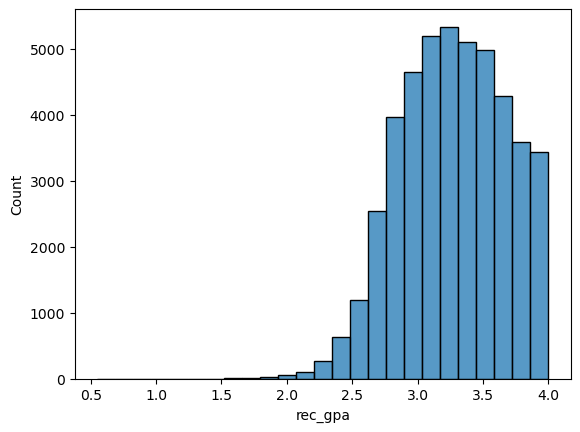

In [234]:
sns.histplot(df['rec_gpa'], bins=25)
plt.show()

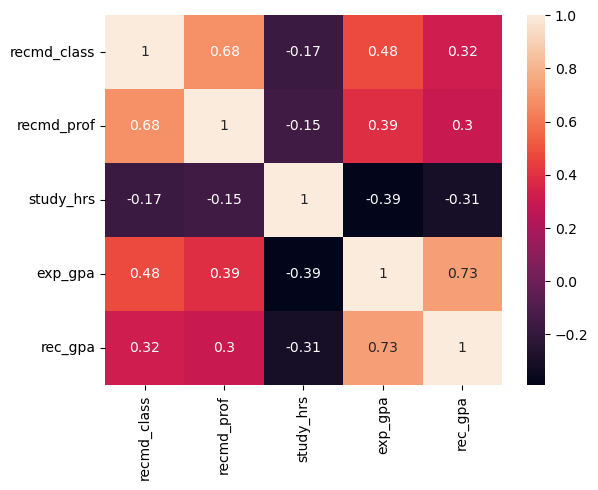

In [241]:
# Correlation
data = df.drop(columns={
    'Instructor',
    'Course',
    'Quarter',
    'Total Enrolled in Course',
    'Total CAPEs Given',
    'exp_letter',
    'rec_letter'
})
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

### Hypothesis Testing

### Regression Analysis